torch.Size([4, 1, 512, 512])


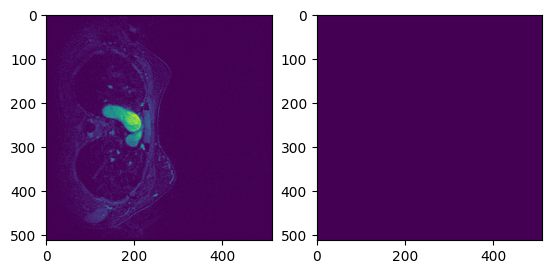

In [33]:
import os
import torch.nn as nn
from tqdm import tqdm
from losses import BCEDiceLoss
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
)
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR

from monai.data import (
    ThreadDataLoader,
    CacheDataset,
    decollate_batch,
)
import torch
from config import *
from dataset import data_dicts
from monai.transforms import (
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
)

num_samples = NUM_SAMPLES
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transforms = Compose(
    [   
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
        #ResizeWithPadOrCropd(keys=["image","label"],spatial_size=[192,512,512],method="symmetric", mode="constant"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-29722.0,
            a_max=32767.0,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=PIX_DIM,
            mode=("bilinear", "nearest"),
        ),
        EnsureTyped(keys=["image", "label"], device=device, track_meta=False),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=IMAGE_SIZE,
            pos=1,
            neg=1,
            num_samples=NUM_SAMPLES,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        # RandShiftIntensityd(
        #     keys=["image"],
        #     offsets=0.10,
        #     prob=0.50,
        # ),
    ]
)

val_transforms = Compose(
    [   
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
        #ResizeWithPadOrCropd(keys=["image","label"],spatial_size=[192,512,512],method="symmetric", mode="constant"),
        ScaleIntensityRanged(keys=["image"], a_min=-29722.0, a_max=32767.0, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=PIX_DIM,
            mode=("bilinear", "nearest"),
        ),
        EnsureTyped(keys=["image", "label"], device=device, track_meta=True),
    ]
)



train_image_paths = "/workspace/breast_mri/2d_train/only_tumor/input"
train_label_paths = "/workspace/breast_mri/2d_train/only_tumor/tumor"
val_image_paths = "/workspace/breast_mri/tumor_tuning_3d/input"
val_label_paths = "/workspace/breast_mri/tumor_tuning_3d/tumor"


train_dataset = CacheDataset(data=data_dicts(train_image_paths,train_label_paths),
                        transform = train_transforms,
                        cache_num=0,
                        cache_rate=0,
                        num_workers=12)

train_loader = ThreadDataLoader(train_dataset, num_workers=0, batch_size=1, shuffle=True)


sample = next(iter(train_loader))
print(sample['image'].shape)

import matplotlib.pyplot as plt
import numpy as np
plt.subplot(1,2,1)
plt.imshow(np.array(sample['image'][1,:,:].cpu()).squeeze())
plt.subplot(1,2,2)
plt.imshow(np.array(sample['label'][1,:,:].cpu()).squeeze())

#print(torch.max(sample[0]))





torch.Size([4, 1, 512, 512])

In [5]:
import os
import nibabel as nib

val_image_paths = "/workspace/breast_mri/tumor_tuning_3d/input"

image_paths = os.listdir(val_image_paths)
image_list = [val_image_paths + "/" + f for f in image_paths]

for f in image_list:
    # .nii.gz 파일 불러오기
    nii_image = nib.load(f)
    # 이미지 데이터 가져오기
    data = nii_image.get_fdata()
    print(data.shape[1],data.shape[2])


512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512


In [4]:

val_label_paths = "/workspace/breast_mri/tumor_tuning_3d/tumor"

image_paths = os.listdir(val_label_paths)
image_list = [val_label_paths + "/" + f for f in image_paths]

for f in image_list:
    # .nii.gz 파일 불러오기
    nii_image = nib.load(f)
    # 이미지 데이터 가져오기
    data = nii_image.get_fdata()
    if data.shape == (95, 384, 588):
        print(f)


/workspace/breast_mri/tumor_tuning_3d/tumor/4475916.nii.gz
